# Phosphodiesterase (PDE) Expression in mPFC Cell Types (10x snRNA-seq)

This notebook examines phosphodiesterase gene expression across neuronal cell types
in the medial prefrontal cortex (PL/ILA/ORB + ACA) using 10x snRNA-seq from the
Allen Brain Cell Atlas.

### Motivation
Phosphodiesterases degrade cyclic nucleotides (cAMP, cGMP) and are critical regulators
of intracellular signaling downstream of neuromodulator receptors. Cell-type-specific
PDE expression determines how neurons respond to dopamine, serotonin, and norepinephrine.

### PDE Gene Panel (17 genes)
- **PDE1** (Ca²⁺/CaM, cAMP+cGMP): Pde1a, Pde1b, Pde1c
- **PDE2** (cGMP-stimulated, dual): Pde2a
- **PDE3** (cGMP-inhibited, cAMP): Pde3a, Pde3b
- **PDE4** (cAMP-specific): Pde4a, Pde4b, Pde4c, Pde4d
- **PDE5** (cGMP-specific): Pde5a
- **PDE7** (cAMP-specific): Pde7a, Pde7b
- **PDE8** (cAMP-specific): Pde8a, Pde8b
- **PDE9** (cGMP-specific): Pde9a
- **PDE10** (dual cAMP+cGMP): Pde10a
- **PDE11** (dual cAMP+cGMP): Pde11a

Excluded: PDE6 (retina-specific), Pde4dip (binding protein), Pde12 (mitochondrial)

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## 1. Load Pre-extracted Expression Data

In [2]:
csv_expr = 'mpfc_pde_expression.csv'
csv_meta = 'mpfc_pde_metadata.csv'

if not os.path.exists(csv_expr):
    raise FileNotFoundError(
        f'{csv_expr} not found. Run extract_mpfc_pde_expression.py first.'
    )

expression_data = pd.read_csv(csv_expr, index_col=0)
metadata = pd.read_csv(csv_meta, index_col=0)
print(f'Expression: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes')
print(f'Metadata: {metadata.shape[0]:,} cells')

Expression: 165,539 cells x 18 genes
Metadata: 165,539 cells


In [3]:
# PDE gene definitions
pde1 = ['Pde1a', 'Pde1b', 'Pde1c']
pde2 = ['Pde2a']
pde3 = ['Pde3a', 'Pde3b']
pde4 = ['Pde4a', 'Pde4b', 'Pde4c', 'Pde4d']
pde5 = ['Pde5a']
pde7 = ['Pde7a', 'Pde7b']
pde8 = ['Pde8a', 'Pde8b']
pde9 = ['Pde9a']
pde10 = ['Pde10a']
pde11 = ['Pde11a']
all_pdes = pde1 + pde2 + pde3 + pde4 + pde5 + pde7 + pde8 + pde9 + pde10 + pde11

pde_genes = [g for g in all_pdes if g in expression_data.columns]
expression_data = expression_data[pde_genes]
print(f'PDE genes: {len(pde_genes)}')
print(pde_genes)

PDE genes: 18
['Pde1a', 'Pde1b', 'Pde1c', 'Pde2a', 'Pde3a', 'Pde3b', 'Pde4a', 'Pde4b', 'Pde4c', 'Pde4d', 'Pde5a', 'Pde7a', 'Pde7b', 'Pde8a', 'Pde8b', 'Pde9a', 'Pde10a', 'Pde11a']


## 2. Overview of mPFC Cell Types

In [4]:
meta = metadata.loc[expression_data.index].copy()
meta['subclass_short'] = meta['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', str(x))
)
meta['supertype_short'] = meta['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', str(x))
)
meta['roi'] = meta['region_of_interest_acronym']

print(f'mPFC cells: {len(meta):,}')
print(f'\nBy dissection region:')
for roi, cnt in meta.groupby('roi', observed=True).size().items():
    print(f'  {roi}: {cnt:,}')

print(f'\nBy subclass:')
sc_counts = meta.groupby('subclass_short', observed=True).size().sort_values(ascending=False)
for sc_name, cnt in sc_counts.items():
    nt = meta[meta['subclass_short'] == sc_name]['neurotransmitter'].mode()
    nt_str = nt.iloc[0] if len(nt) > 0 else ''
    print(f'  {sc_name}: {cnt:,} ({nt_str})')

mPFC cells: 165,539

By dissection region:
  ACA: 80,025
  PL-ILA-ORB: 85,514

By subclass:
  L6 CT CTX Glut: 38,354 (Glut)
  L4/5 IT CTX Glut: 23,357 (Glut)
  L6 IT CTX Glut: 20,452 (Glut)
  L2/3 IT CTX Glut: 18,401 (Glut)
  L5 IT CTX Glut: 15,020 (Glut)
  Sst Gaba: 9,267 (GABA)
  L5 NP CTX Glut: 7,529 (Glut)
  Vip Gaba: 7,209 (GABA)
  L5 ET CTX Glut: 5,710 (Glut)
  Lamp5 Gaba: 5,211 (GABA)
  Pvalb Gaba: 4,852 (GABA)
  L6b CTX Glut: 3,295 (Glut)
  L2/3 IT RSP Glut: 2,666 (Glut)
  Sncg Gaba: 2,452 (GABA)
  L4 RSP-ACA Glut: 675 (Glut)
  Sst Chodl Gaba: 418 (GABA)
  Lamp5 Lhx6 Gaba: 389 (GABA)
  Pvalb chandelier Gaba: 282 (GABA)


## 3. Dot Plot: PDE Expression by Subclass

AnnData: 165,539 cells x 18 genes, 18 subclasses


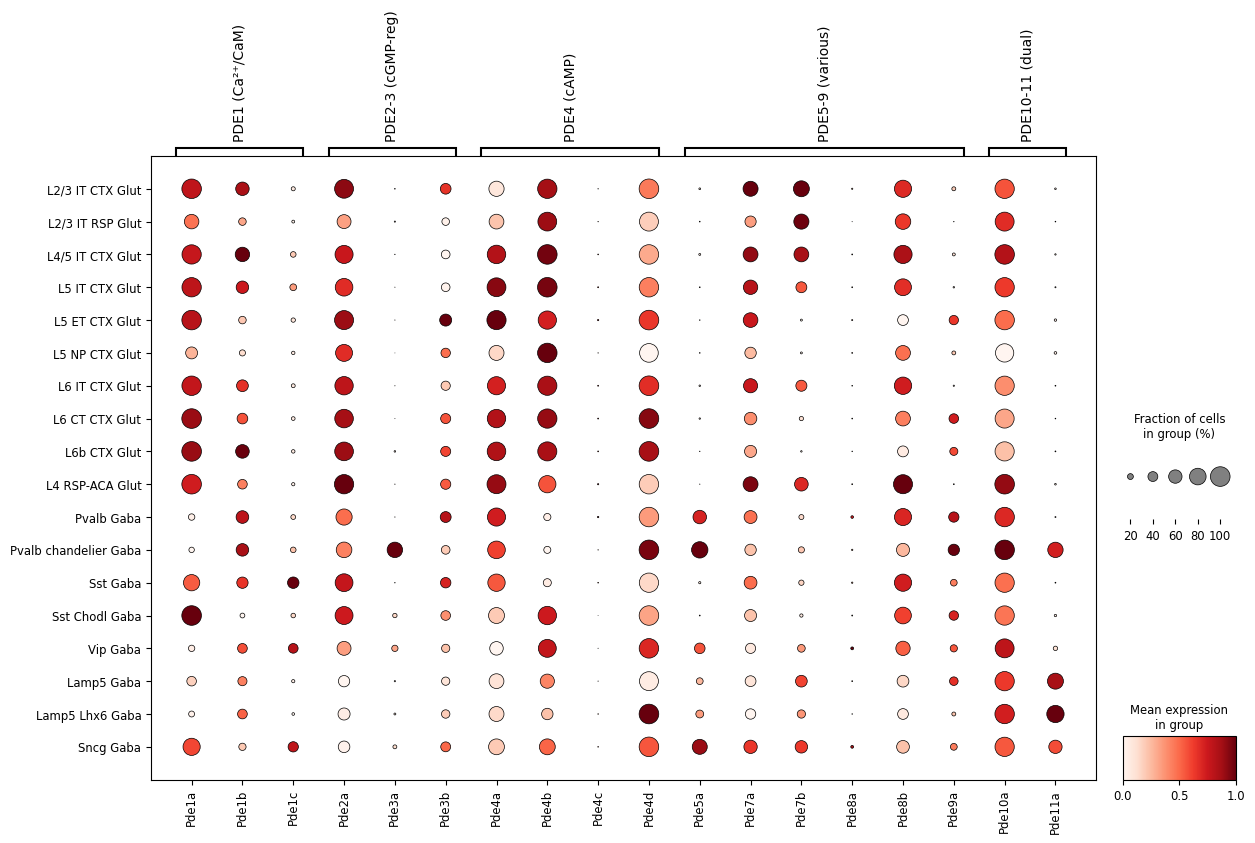

Saved: dotplot_mPFC_PDE_by_subclass.png


In [5]:
# Build AnnData
adata = anndata.AnnData(
    X=expression_data.values,
    obs=meta[['subclass_short', 'supertype_short', 'roi', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=pde_genes)
)

# Sort subclasses: excitatory by layer, then interneurons
def subclass_sort_key(name):
    if 'L2/3' in name:
        return (0, name)
    elif 'L4' in name and 'RSP' not in name:
        return (1, name)
    elif 'L5 IT' in name:
        return (2, name)
    elif 'L5 ET' in name:
        return (3, name)
    elif 'L5 NP' in name:
        return (4, name)
    elif 'L6 IT' in name:
        return (5, name)
    elif 'L6 CT' in name:
        return (6, name)
    elif 'L6b' in name:
        return (7, name)
    elif 'RSP' in name:
        return (8, name)
    elif 'Glut' in name:
        return (9, name)
    elif 'Pvalb' in name and 'chand' not in name:
        return (10, name)
    elif 'chandelier' in name:
        return (11, name)
    elif 'Sst' in name and 'Chodl' not in name:
        return (12, name)
    elif 'Chodl' in name:
        return (13, name)
    elif 'Vip' in name:
        return (14, name)
    elif 'Lamp5' in name and 'Lhx6' not in name:
        return (15, name)
    elif 'Lhx6' in name:
        return (16, name)
    elif 'Sncg' in name:
        return (17, name)
    else:
        return (18, name)

sorted_sc = sorted(sc_counts.index.tolist(), key=subclass_sort_key)
adata.obs['subclass_short'] = pd.Categorical(
    adata.obs['subclass_short'], categories=sorted_sc, ordered=True
)

# Group PDE genes by family
pde_groups = {
    'PDE1 (Ca²⁺/CaM)': [g for g in pde1 if g in pde_genes],
    'PDE2-3 (cGMP-reg)': [g for g in pde2 + pde3 if g in pde_genes],
    'PDE4 (cAMP)': [g for g in pde4 if g in pde_genes],
    'PDE5-9 (various)': [g for g in pde5 + pde7 + pde8 + pde9 if g in pde_genes],
    'PDE10-11 (dual)': [g for g in pde10 + pde11 if g in pde_genes],
}
pde_groups = {k: v for k, v in pde_groups.items() if v}

n_sc = len(sorted_sc)
print(f'AnnData: {adata.shape[0]:,} cells x {adata.shape[1]} genes, {n_sc} subclasses')

dp = sc.pl.dotplot(
    adata,
    var_names=pde_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(14, max(5, n_sc * 0.45)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_mPFC_PDE_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_mPFC_PDE_by_subclass.png')

## 4. Dot Plot: PDE Expression by Supertype

Finer-grained view at the supertype level.

Supertypes with >= 50 cells: 86


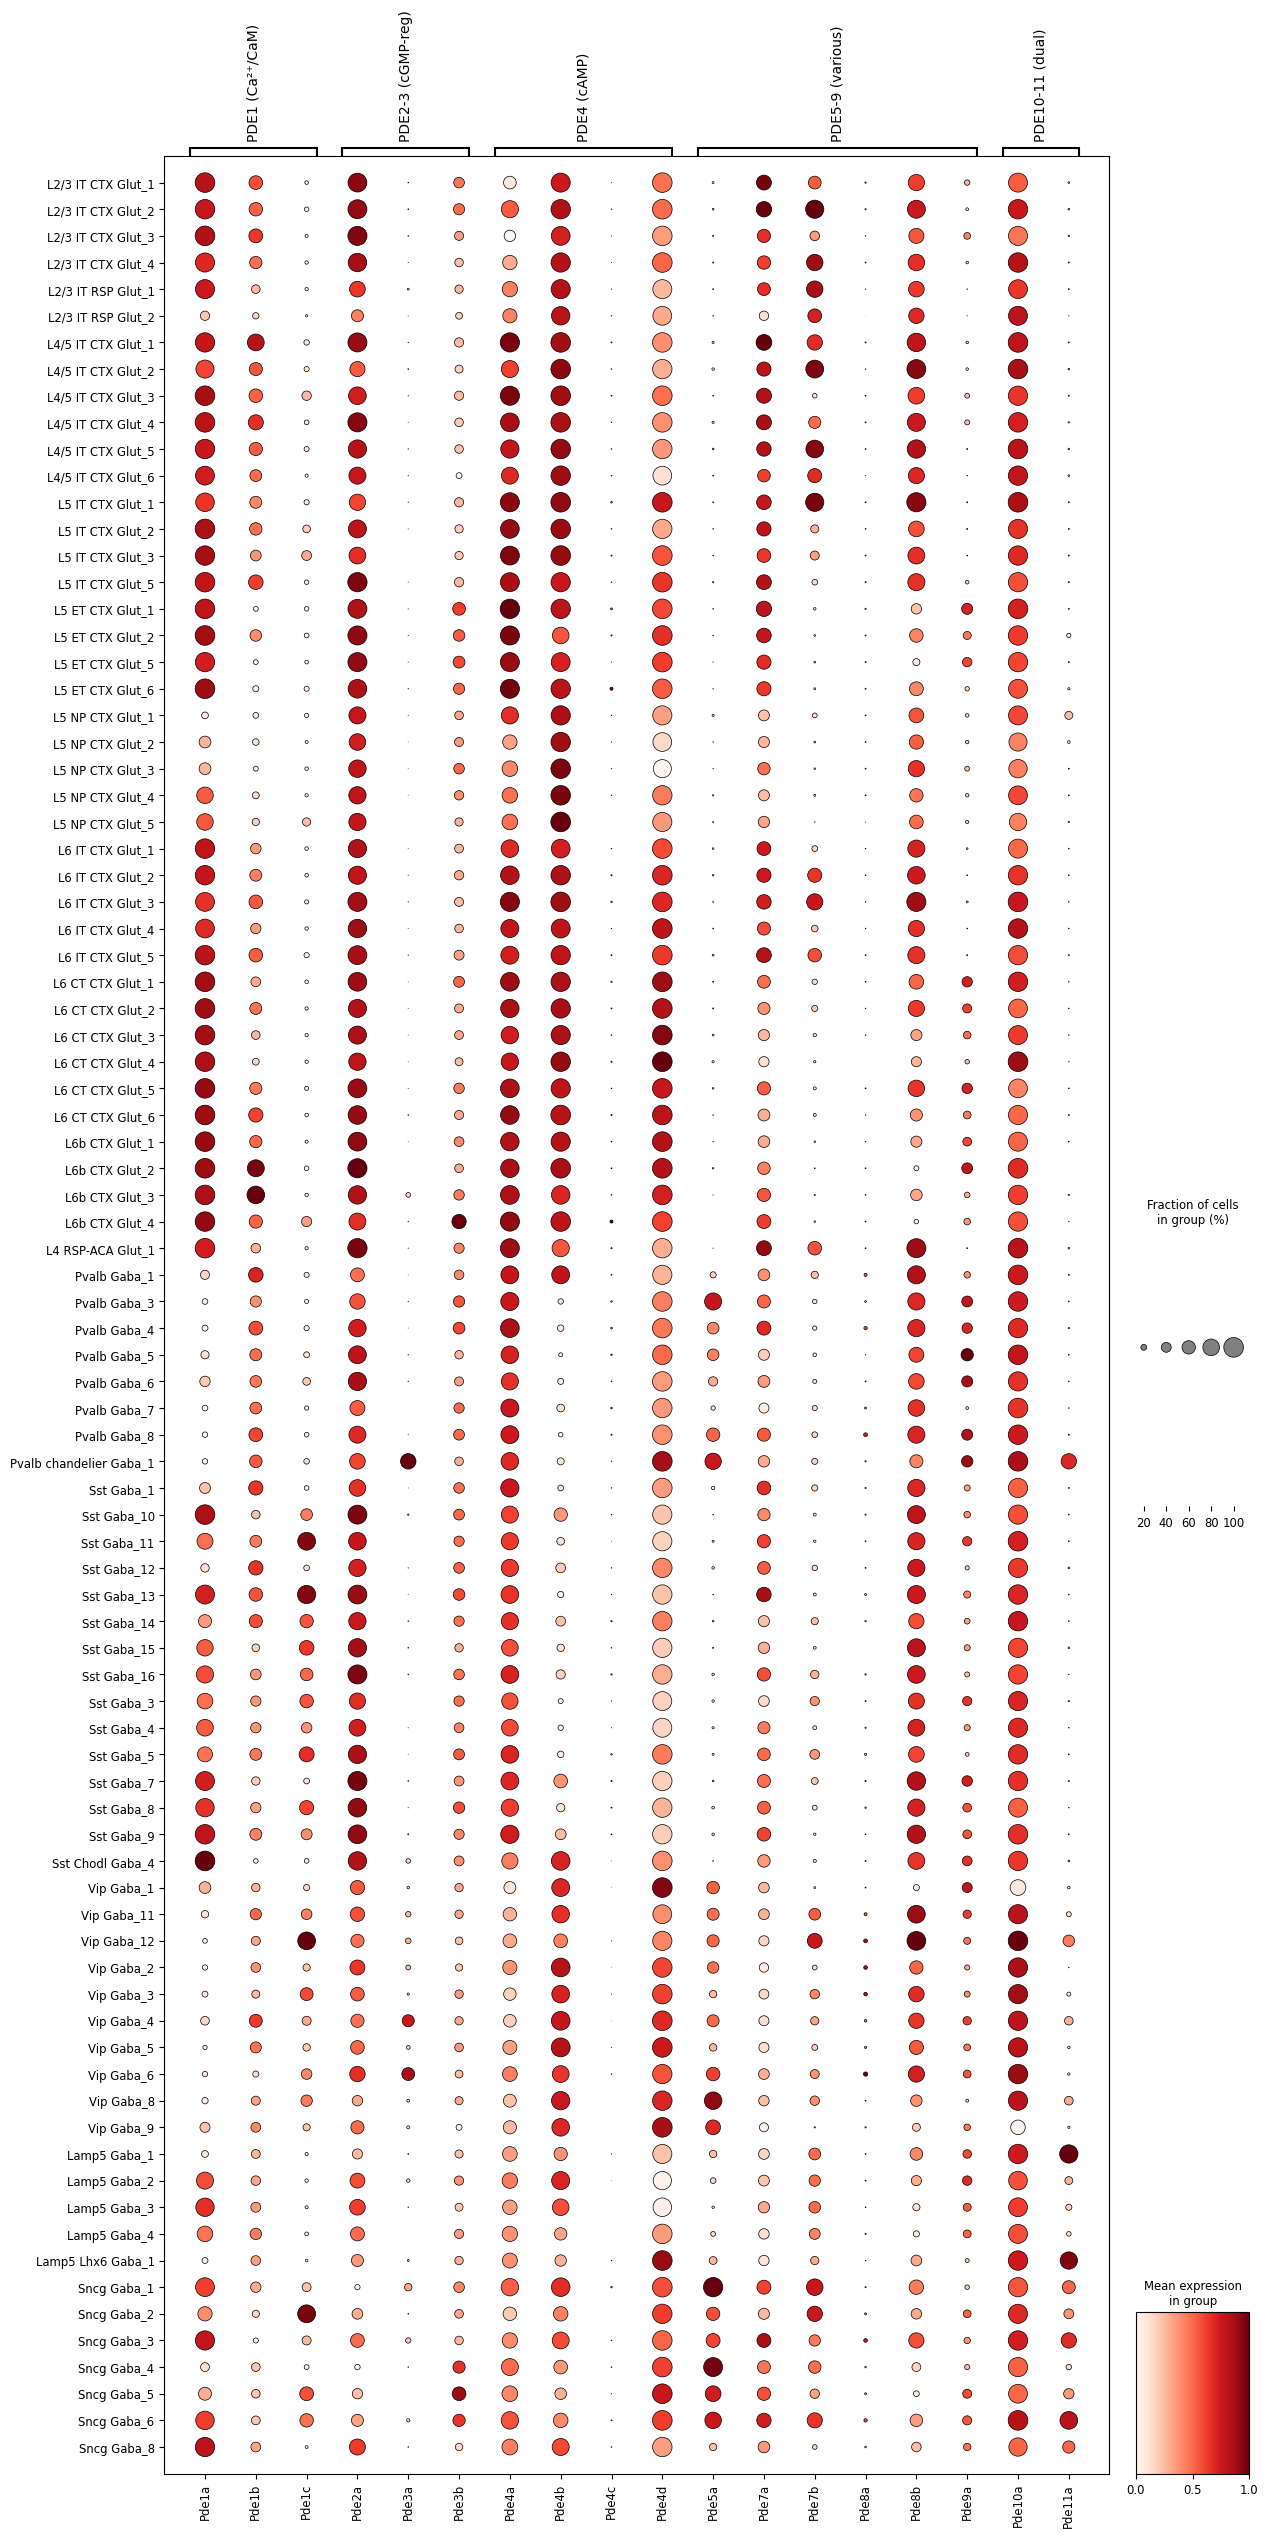

Saved: dotplot_mPFC_PDE_by_supertype.png


In [6]:
# Supertype counts
st_counts = meta.groupby('supertype_short', observed=True).size().sort_values(ascending=False)
valid_st = st_counts[st_counts >= 50].index.tolist()
print(f'Supertypes with >= 50 cells: {len(valid_st)}')

adata_st = adata[adata.obs['supertype_short'].isin(valid_st)].copy()

# Sort supertypes by subclass then name
st_to_sc = meta.groupby('supertype_short', observed=True)['subclass_short'].first()
sorted_st = sorted(valid_st, key=lambda st: (
    subclass_sort_key(st_to_sc.get(st, '')),
    st
))

adata_st.obs['supertype_short'] = pd.Categorical(
    adata_st.obs['supertype_short'], categories=sorted_st, ordered=True
)

n_st = len(sorted_st)
dp2 = sc.pl.dotplot(
    adata_st,
    var_names=pde_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(14, max(8, n_st * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_mPFC_PDE_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_mPFC_PDE_by_supertype.png')

## 5. Heatmap: Mean Expression and Fraction Expressing

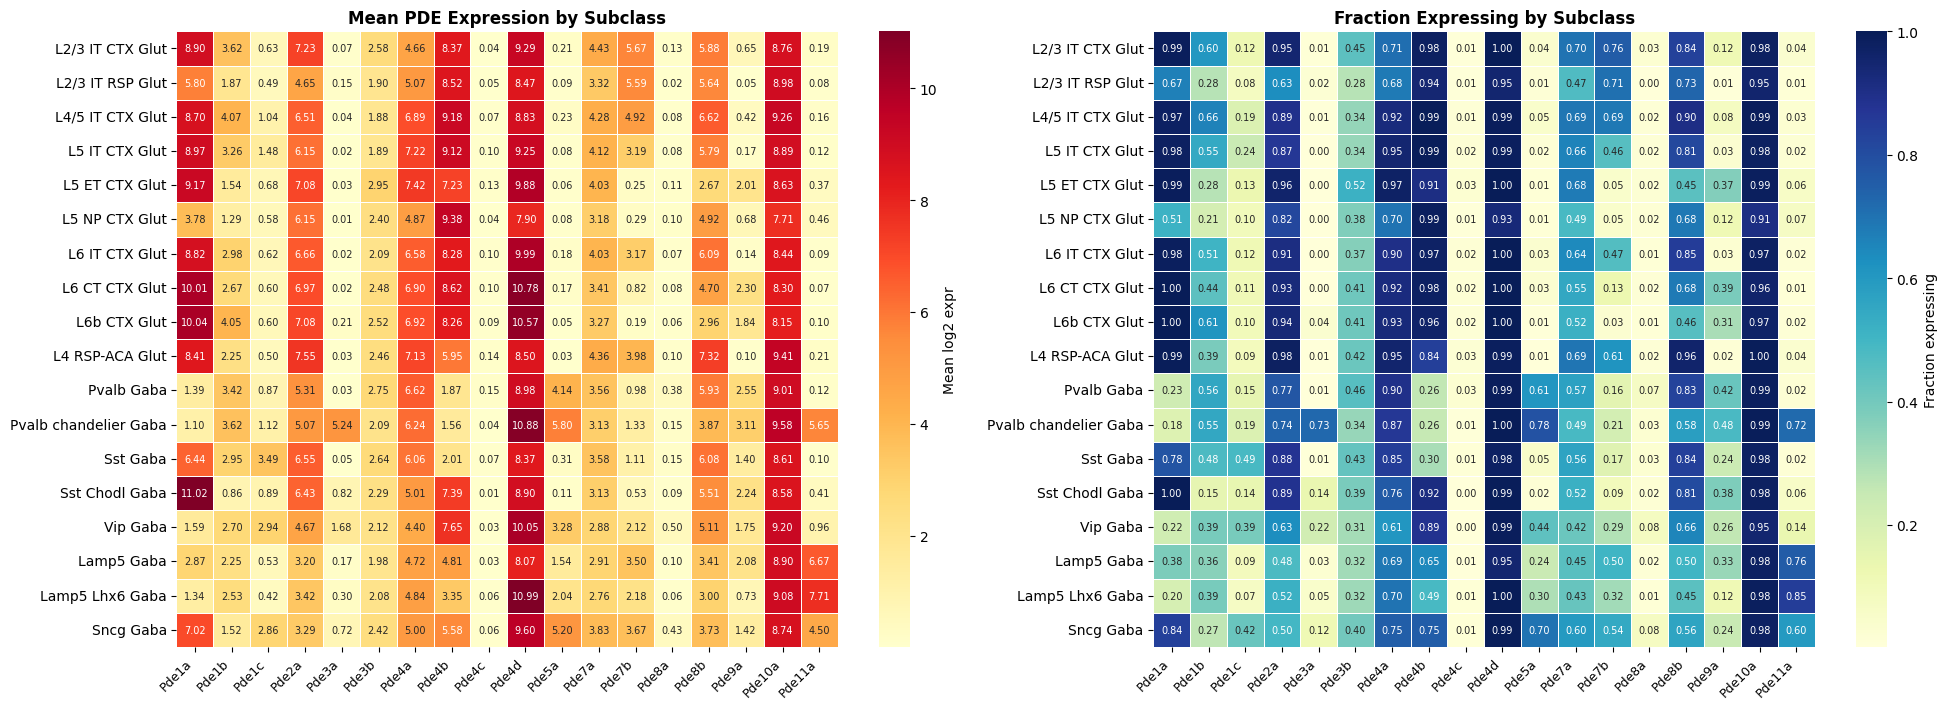

Saved: heatmap_mPFC_PDE_by_subclass.png


In [7]:
# Mean expression and fraction by subclass
expr_df = pd.DataFrame(adata.X, index=adata.obs.index, columns=pde_genes)
expr_df['subclass'] = adata.obs['subclass_short'].values

sc_mean = expr_df.groupby('subclass', observed=True)[pde_genes].mean().loc[sorted_sc]
sc_frac = expr_df.groupby('subclass', observed=True)[pde_genes].apply(
    lambda x: (x > 0).mean()
).loc[sorted_sc]

fig, axes = plt.subplots(1, 2, figsize=(20, max(5, n_sc * 0.4)))

sns.heatmap(sc_mean, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0],
            linewidths=0.5, cbar_kws={'label': 'Mean log2 expr'},
            annot_kws={'size': 7})
axes[0].set_title('Mean PDE Expression by Subclass', fontweight='bold')
axes[0].set_ylabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=9)

sns.heatmap(sc_frac, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1],
            linewidths=0.5, cbar_kws={'label': 'Fraction expressing'},
            annot_kws={'size': 7})
axes[1].set_title('Fraction Expressing by Subclass', fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.savefig('heatmap_mPFC_PDE_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_mPFC_PDE_by_subclass.png')

## 6. Enrichment: Excitatory vs Inhibitory PDE Profiles

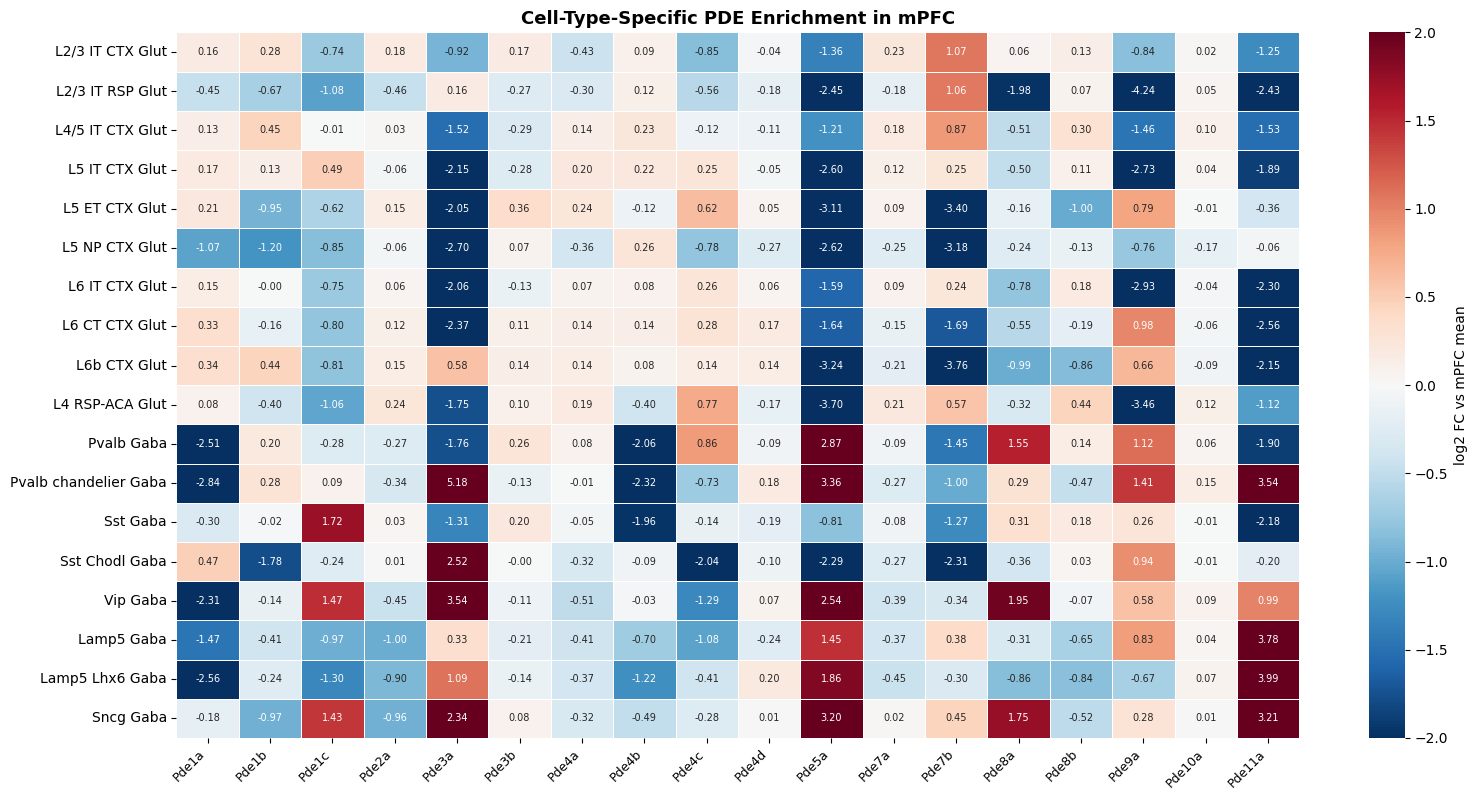

Saved: heatmap_mPFC_PDE_enrichment.png

Key cell-type-specific PDE enrichments (|log2FC| > 0.5):
  L2/3 IT CTX Glut              : Pde1c(-0.7), Pde3a(-0.9), Pde4c(-0.9), Pde5a(-1.4), Pde7b(+1.1), Pde9a(-0.8), Pde11a(-1.3)
  L2/3 IT RSP Glut              : Pde1b(-0.7), Pde1c(-1.1), Pde4c(-0.6), Pde5a(-2.5), Pde7b(+1.1), Pde8a(-2.0), Pde9a(-4.2), Pde11a(-2.4)
  L4/5 IT CTX Glut              : Pde3a(-1.5), Pde5a(-1.2), Pde7b(+0.9), Pde8a(-0.5), Pde9a(-1.5), Pde11a(-1.5)
  L5 IT CTX Glut                : Pde3a(-2.1), Pde5a(-2.6), Pde9a(-2.7), Pde11a(-1.9)
  L5 ET CTX Glut                : Pde1b(-0.9), Pde1c(-0.6), Pde3a(-2.0), Pde4c(+0.6), Pde5a(-3.1), Pde7b(-3.4), Pde8b(-1.0), Pde9a(+0.8)
  L5 NP CTX Glut                : Pde1a(-1.1), Pde1b(-1.2), Pde1c(-0.8), Pde3a(-2.7), Pde4c(-0.8), Pde5a(-2.6), Pde7b(-3.2), Pde9a(-0.8)
  L6 IT CTX Glut                : Pde1c(-0.7), Pde3a(-2.1), Pde5a(-1.6), Pde8a(-0.8), Pde9a(-2.9), Pde11a(-2.3)
  L6 CT CTX Glut                : Pde1c(-0.8), Pde3a(-2.

In [8]:
# Log2 fold-change vs overall mPFC mean
overall_mean = expr_df[pde_genes].mean()
pseudocount = 0.01
log2fc = np.log2((sc_mean + pseudocount) / (overall_mean + pseudocount))

fig, ax = plt.subplots(figsize=(16, max(5, n_sc * 0.45)))
sns.heatmap(log2fc, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, linewidths=0.5, vmin=-2, vmax=2,
            cbar_kws={'label': 'log2 FC vs mPFC mean'},
            annot_kws={'size': 7})
ax.set_title('Cell-Type-Specific PDE Enrichment in mPFC',
             fontweight='bold', fontsize=13)
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.savefig('heatmap_mPFC_PDE_enrichment.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_mPFC_PDE_enrichment.png')

print('\nKey cell-type-specific PDE enrichments (|log2FC| > 0.5):')
for sc_name in sorted_sc:
    hits = []
    for g in pde_genes:
        fc = log2fc.loc[sc_name, g]
        if abs(fc) > 0.5:
            direction = '+' if fc > 0 else '-'
            hits.append(f'{g}({direction}{abs(fc):.1f})')
    if hits:
        print(f'  {sc_name:30s}: {", ".join(hits)}')

## 7. Excitatory vs Inhibitory Comparison

Compare PDE expression profiles between excitatory and inhibitory neurons.

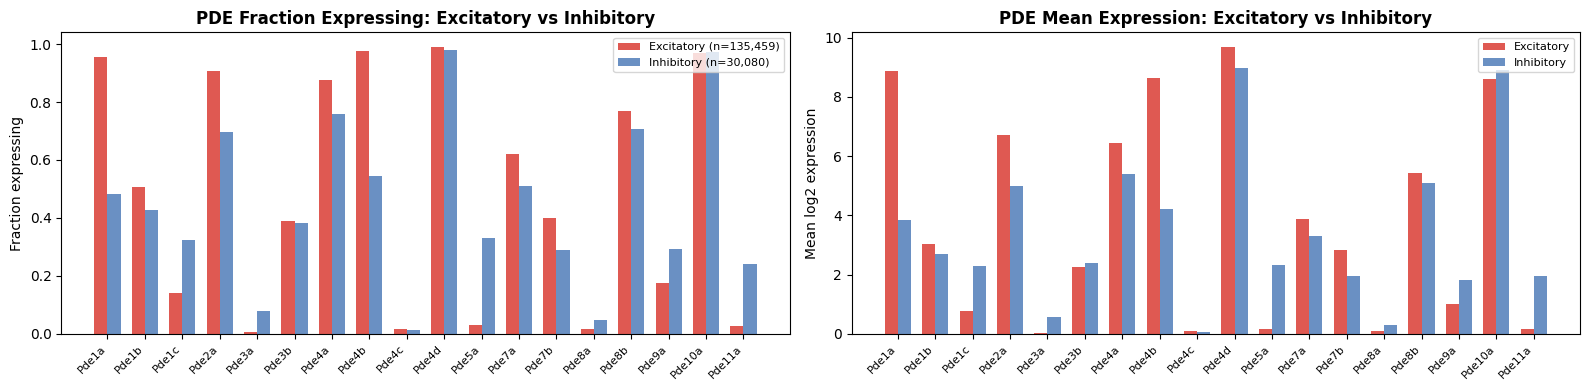

Saved: barplot_mPFC_PDE_excitatory_vs_inhibitory.png


In [9]:
# Excitatory vs inhibitory
expr_df['cell_class'] = 'Excitatory'
inhib_subclasses = ['Pvalb Gaba', 'Pvalb chandelier Gaba', 'Sst Gaba',
                     'Sst Chodl Gaba', 'Vip Gaba', 'Lamp5 Gaba',
                     'Lamp5 Lhx6 Gaba', 'Sncg Gaba']
expr_df.loc[expr_df['subclass'].isin(inhib_subclasses), 'cell_class'] = 'Inhibitory'

class_mean = expr_df.groupby('cell_class', observed=True)[pde_genes].mean()
class_frac = expr_df.groupby('cell_class', observed=True)[pde_genes].apply(
    lambda x: (x > 0).mean()
)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

x = np.arange(len(pde_genes))
width = 0.35

# Fraction expressing
ax = axes[0]
ax.bar(x - width/2, class_frac.loc['Excitatory'], width,
       label=f'Excitatory (n={(expr_df["cell_class"]=="Excitatory").sum():,})',
       color='#d73027', alpha=0.8)
ax.bar(x + width/2, class_frac.loc['Inhibitory'], width,
       label=f'Inhibitory (n={(expr_df["cell_class"]=="Inhibitory").sum():,})',
       color='#4575b4', alpha=0.8)
ax.set_ylabel('Fraction expressing')
ax.set_title('PDE Fraction Expressing: Excitatory vs Inhibitory', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pde_genes, rotation=45, ha='right', fontsize=8)
ax.legend(fontsize=8)

# Mean expression
ax = axes[1]
ax.bar(x - width/2, class_mean.loc['Excitatory'], width,
       label='Excitatory', color='#d73027', alpha=0.8)
ax.bar(x + width/2, class_mean.loc['Inhibitory'], width,
       label='Inhibitory', color='#4575b4', alpha=0.8)
ax.set_ylabel('Mean log2 expression')
ax.set_title('PDE Mean Expression: Excitatory vs Inhibitory', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pde_genes, rotation=45, ha='right', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('barplot_mPFC_PDE_excitatory_vs_inhibitory.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: barplot_mPFC_PDE_excitatory_vs_inhibitory.png')

## 8. Summary Statistics

In [10]:
print('=' * 80)
print('Mean Expression (log2) — PDE Genes by mPFC Subclass (10x snRNA-seq)')
print('=' * 80)
display(sc_mean.round(3))

print('\n' + '=' * 80)
print('Fraction Expressing — PDE Genes by mPFC Subclass (10x snRNA-seq)')
print('=' * 80)
display(sc_frac.round(3))

# Save CSVs
sc_mean.to_csv('mpfc_pde_subclass_mean_expression.csv')
sc_frac.to_csv('mpfc_pde_subclass_frac_expressing.csv')
log2fc.to_csv('mpfc_pde_subclass_enrichment.csv')
print('\nSaved summary CSVs.')

# CV across subclasses
cv_frac = sc_frac.std() / sc_frac.mean()
print(f'\nCell-type variation (CV of fraction expressing):')
for g in pde_genes:
    print(f'  {g:>10s}: CV={cv_frac[g]:.3f}  range=[{sc_frac[g].min():.3f} - {sc_frac[g].max():.3f}]')

print(f'\nMost cell-type-variable PDE: {cv_frac.idxmax()} (CV={cv_frac.max():.3f})')
print(f'Most ubiquitous PDE: {cv_frac.idxmin()} (CV={cv_frac.min():.3f})')

print(f'\n{"=" * 80}')
print('Summary')
print(f'{"=" * 80}')
print(f'Total mPFC cells: {len(expression_data):,}')
print(f'Subclasses: {n_sc}')
print(f'PDE genes: {len(pde_genes)}')

Mean Expression (log2) — PDE Genes by mPFC Subclass (10x snRNA-seq)


,Pde1a,Pde1b,Pde1c,Pde2a,Pde3a,Pde3b,Pde4a,Pde4b,Pde4c,Pde4d,Pde5a,Pde7a,Pde7b,Pde8a,Pde8b,Pde9a,Pde10a,Pde11a
subclass,,,,,,,,,,,,,,,,,,
L2/3 IT CTX Glut,8.903,3.615,0.627,7.227,0.067,2.575,4.660,8.370,0.039,9.293,0.211,4.433,5.665,0.127,5.879,0.647,8.763,0.194
L2/3 IT RSP Glut,5.799,1.869,0.493,4.648,0.152,1.904,5.070,8.522,0.050,8.471,0.093,3.324,5.590,0.023,5.643,0.052,8.978,0.080
L4/5 IT CTX Glut,8.701,4.070,1.043,6.512,0.041,1.875,6.892,9.179,0.071,8.834,0.235,4.283,4.919,0.082,6.615,0.418,9.258,0.159
L5 IT CTX Glut,8.967,3.261,1.480,6.153,0.023,1.890,7.215,9.122,0.095,9.252,0.083,4.120,3.190,0.083,5.790,0.167,8.893,0.122
L5 ET CTX Glut,9.169,1.539,0.681,7.080,0.025,2.947,7.418,7.230,0.125,9.883,0.056,4.030,0.245,0.107,2.675,2.014,8.631,0.369
L5 NP CTX Glut,3.779,1.294,0.580,6.150,0.012,2.397,4.873,9.377,0.041,7.905,0.082,3.177,0.287,0.102,4.917,0.684,7.709,0.456
L6 IT CTX Glut,8.820,2.980,0.622,6.662,0.025,2.095,6.576,8.276,0.096,9.985,0.178,4.031,3.173,0.066,6.091,0.144,8.437,0.089
L6 CT CTX Glut,10.007,2.674,0.602,6.973,0.018,2.476,6.903,8.623,0.097,10.784,0.171,3.410,0.825,0.080,4.699,2.302,8.300,0.072
L6b CTX Glut,10.041,4.046,0.598,7.085,0.207,2.517,6.923,8.265,0.088,10.569,0.050,3.274,0.189,0.056,2.957,1.843,8.146,0.100



Fraction Expressing — PDE Genes by mPFC Subclass (10x snRNA-seq)


,Pde1a,Pde1b,Pde1c,Pde2a,Pde3a,Pde3b,Pde4a,Pde4b,Pde4c,Pde4d,Pde5a,Pde7a,Pde7b,Pde8a,Pde8b,Pde9a,Pde10a,Pde11a
subclass,,,,,,,,,,,,,,,,,,
L2/3 IT CTX Glut,0.991,0.604,0.122,0.948,0.013,0.446,0.711,0.977,0.008,0.997,0.041,0.699,0.757,0.026,0.836,0.118,0.978,0.037
L2/3 IT RSP Glut,0.668,0.280,0.078,0.633,0.024,0.281,0.684,0.944,0.008,0.952,0.015,0.473,0.706,0.004,0.731,0.008,0.953,0.013
L4/5 IT CTX Glut,0.975,0.664,0.188,0.894,0.008,0.338,0.924,0.995,0.014,0.989,0.046,0.690,0.687,0.017,0.903,0.080,0.992,0.029
L5 IT CTX Glut,0.979,0.547,0.242,0.866,0.004,0.335,0.946,0.993,0.019,0.987,0.016,0.660,0.457,0.018,0.815,0.032,0.979,0.022
L5 ET CTX Glut,0.992,0.279,0.134,0.957,0.005,0.520,0.970,0.908,0.027,0.999,0.011,0.677,0.047,0.023,0.449,0.371,0.987,0.061
L5 NP CTX Glut,0.515,0.212,0.097,0.821,0.002,0.376,0.698,0.988,0.007,0.933,0.014,0.487,0.046,0.018,0.685,0.116,0.909,0.069
L6 IT CTX Glut,0.985,0.506,0.116,0.914,0.005,0.365,0.900,0.970,0.018,0.999,0.034,0.645,0.465,0.014,0.849,0.027,0.975,0.016
L6 CT CTX Glut,0.999,0.444,0.108,0.927,0.003,0.411,0.919,0.976,0.018,1.000,0.031,0.548,0.130,0.015,0.684,0.386,0.959,0.013
L6b CTX Glut,0.999,0.614,0.101,0.935,0.035,0.410,0.929,0.962,0.016,1.000,0.008,0.524,0.032,0.010,0.456,0.305,0.967,0.017



Saved summary CSVs.

Cell-type variation (CV of fraction expressing):
       Pde1a: CV=0.463  range=[0.181 - 0.999]
       Pde1b: CV=0.349  range=[0.153 - 0.664]
       Pde1c: CV=0.705  range=[0.069 - 0.487]
       Pde2a: CV=0.213  range=[0.480 - 0.978]
       Pde3a: CV=2.231  range=[0.002 - 0.727]
       Pde3b: CV=0.160  range=[0.281 - 0.520]
       Pde4a: CV=0.144  range=[0.608 - 0.970]
       Pde4b: CV=0.344  range=[0.255 - 0.995]
       Pde4c: CV=0.590  range=[0.002 - 0.029]
       Pde4d: CV=0.020  range=[0.933 - 1.000]
       Pde5a: CV=1.420  range=[0.006 - 0.784]
       Pde7a: CV=0.171  range=[0.416 - 0.699]
       Pde7b: CV=0.718  range=[0.032 - 0.757]
       Pde8a: CV=0.824  range=[0.004 - 0.077]
       Pde8b: CV=0.238  range=[0.447 - 0.960]
       Pde9a: CV=0.716  range=[0.008 - 0.482]
      Pde10a: CV=0.021  range=[0.909 - 0.996]
      Pde11a: CV=1.558  range=[0.013 - 0.846]

Most cell-type-variable PDE: Pde3a (CV=2.231)
Most ubiquitous PDE: Pde4d (CV=0.020)

Summary
Total m